# Variational Autoencoder (VAE) on MNIST (2D latent) + 3D Plotly Visualization
This notebook implements and trains a multilayer neural network–based Variational Autoencoder on the MNIST dataset using a two-dimensional latent space. The learned latent representation is then visualized in three dimensions using Plotly for interactive exploration.

Farhad Kamangar
February 2026
(Developed with assistance from ChatGPT v5.2)

In [1]:
!pip -q install plotly

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import plotly.express as px
import plotly.graph_objects as go

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),  # MNIST -> [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.35MB/s]


(60000, 10000)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=400):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 784 -> hidden -> (mu, logvar)
        self.enc_fc1 = nn.Linear(28*28, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: latent -> hidden -> 784
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_out = nn.Linear(hidden_dim, 28*28)

    def encode(self, x):
        x = x.view(x.size(0), -1)              # (B, 784)
        h = F.relu(self.enc_fc1(x))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # z = mu + std * eps
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        logits = self.dec_out(h)
        xhat = torch.sigmoid(logits)           # Bernoulli probs in [0,1]
        return xhat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar, z

model = VAE(latent_dim=2, hidden_dim=400).to(device)
model


VAE(
  (enc_fc1): Linear(in_features=784, out_features=400, bias=True)
  (enc_mu): Linear(in_features=400, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=400, out_features=2, bias=True)
  (dec_fc1): Linear(in_features=2, out_features=400, bias=True)
  (dec_out): Linear(in_features=400, out_features=784, bias=True)
)

In [4]:
def vae_loss(x, xhat, mu, logvar):
    # Reconstruction term (sum over pixels, then mean over batch)
    x_flat = x.view(x.size(0), -1)
    xhat_flat = xhat.view(xhat.size(0), -1)
    recon = F.binary_cross_entropy(xhat_flat, x_flat, reduction="sum") / x.size(0)

    # KL divergence term (mean over batch)
    # KL(q(z|x) || p(z)) where q is N(mu, diag(exp(logvar))) and p is N(0, I)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon + kl, recon, kl


In [5]:
lr = 1e-3
epochs = 8
opt = torch.optim.Adam(model.parameters(), lr=lr)

def train_one_epoch():
    model.train()
    total, total_recon, total_kl = 0.0, 0.0, 0.0
    for xb, _ in train_dl:
        xb = xb.to(device)
        xhat, mu, logvar, _ = model(xb)
        loss, recon, kl = vae_loss(xb, xhat, mu, logvar)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        total += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    n = len(train_dl)
    return total/n, total_recon/n, total_kl/n

@torch.no_grad()
def eval_one_epoch():
    model.eval()
    total, total_recon, total_kl = 0.0, 0.0, 0.0
    for xb, _ in test_dl:
        xb = xb.to(device)
        xhat, mu, logvar, _ = model(xb)
        loss, recon, kl = vae_loss(xb, xhat, mu, logvar)
        total += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    n = len(test_dl)
    return total/n, total_recon/n, total_kl/n

for ep in range(1, epochs+1):
    tr = train_one_epoch()
    te = eval_one_epoch()
    print(f"Epoch {ep:02d} | train loss {tr[0]:.3f} (recon {tr[1]:.3f}, kl {tr[2]:.3f})"
          f" | test loss {te[0]:.3f} (recon {te[1]:.3f}, kl {te[2]:.3f})")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 01 | train loss 207.769 (recon 201.606, kl 6.164) | test loss 179.952 (recon 174.045, kl 5.908)
Epoch 02 | train loss 174.819 (recon 169.373, kl 5.446) | test loss 169.225 (recon 163.821, kl 5.404)
Epoch 03 | train loss 167.099 (recon 161.885, kl 5.214) | test loss 164.942 (recon 159.613, kl 5.330)
Epoch 04 | train loss 163.732 (recon 158.485, kl 5.247) | test loss 162.664 (recon 157.407, kl 5.258)
Epoch 05 | train loss 161.898 (recon 156.594, kl 5.304) | test loss 161.459 (recon 156.111, kl 5.349)
Epoch 06 | train loss 160.651 (recon 155.288, kl 5.363) | test loss 160.517 (recon 155.156, kl 5.361)
Epoch 07 | train loss 159.609 (recon 154.190, kl 5.419) | test loss 159.586 (recon 154.056, kl 5.530)
Epoch 08 | train loss 158.802 (recon 153.330, kl 5.472) | test loss 158.940 (recon 153.303, kl 5.637)


In [6]:
@torch.no_grad()
def collect_latents(dl, max_batches=None):
    model.eval()
    Z = []
    Y = []
    ERR = []
    batches = 0
    for xb, yb in dl:
        xb = xb.to(device)
        xhat, mu, logvar, z = model(xb)

        # per-sample reconstruction error (mean BCE per image)
        x_flat = xb.view(xb.size(0), -1)
        xhat_flat = xhat.view(xhat.size(0), -1)
        per_img = F.binary_cross_entropy(xhat_flat, x_flat, reduction="none").mean(dim=1)

        Z.append(mu.cpu().numpy())         # use mu for plotting
        Y.append(yb.numpy())
        ERR.append(per_img.cpu().numpy())

        batches += 1
        if max_batches is not None and batches >= max_batches:
            break

    Z = np.concatenate(Z, axis=0)   # (N, 2)
    Y = np.concatenate(Y, axis=0)   # (N,)
    ERR = np.concatenate(ERR, axis=0)
    return Z, Y, ERR

Z, Y, ERR = collect_latents(test_dl)  # full test set
Z.shape, Y.shape, ERR.shape


((10000, 2), (10000,), (10000,))

## 3D Plotly latent space
A 2D latent space is shown in 3D by choosing a third axis. Below we use (1) digit label and (2) reconstruction error.

In [7]:
fig = px.scatter_3d(
    x=Z[:,0], y=Z[:,1], z=Y,
    color=Y.astype(str),
    labels={"x":"z1 (mu)", "y":"z2 (mu)", "z":"digit"},
    title="VAE latent space (2D) shown in 3D: z-axis = digit label",
    opacity=0.8
)
fig.update_traces(marker=dict(size=3))
fig.show()


In [8]:
fig = px.scatter_3d(
    x=Z[:,0], y=Z[:,1], z=ERR,
    color=Y.astype(str),
    labels={"x":"z1 (mu)", "y":"z2 (mu)", "z":"reconstruction error"},
    title="VAE latent space (2D) shown in 3D: z-axis = reconstruction error",
    opacity=0.8
)
fig.update_traces(marker=dict(size=3))
fig.show()


In [9]:
import pandas as pd

df = pd.DataFrame({
    "z1": Z[:,0],
    "z2": Z[:,1],
    "label": Y,
    "recon_err": ERR
})

fig = px.scatter_3d(
    df, x="z1", y="z2", z="recon_err",
    color=df["label"].astype(str),
    hover_data=["label", "recon_err"],
    title="Latent space with hover info"
)
fig.update_traces(marker=dict(size=3))
fig.show()


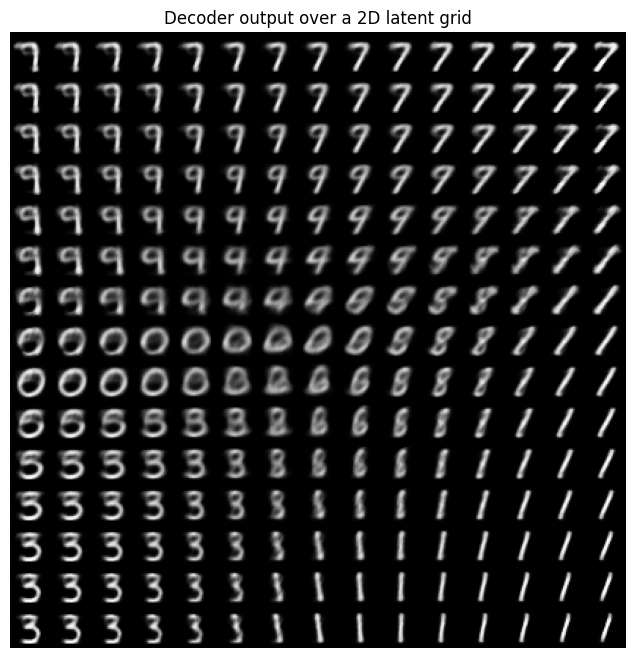

In [10]:
import matplotlib.pyplot as plt

@torch.no_grad()
def decode_grid(n=15, zmin=-3.0, zmax=3.0):
    model.eval()
    zs = np.linspace(zmin, zmax, n)
    canvas = np.zeros((28*n, 28*n))
    for i, y in enumerate(zs):
        for j, x in enumerate(zs):
            z = torch.tensor([[x, y]], dtype=torch.float32, device=device)
            xhat = model.decode(z).cpu().numpy()[0,0]
            canvas[(n-1-i)*28:(n-i)*28, j*28:(j+1)*28] = xhat  # flip y for display
    return canvas

canvas = decode_grid(n=15, zmin=-3, zmax=3)

plt.figure(figsize=(8,8))
plt.imshow(canvas, cmap="gray")
plt.axis("off")
plt.title("Decoder output over a 2D latent grid")
plt.show()
